## Recurrent neural networks

The place to start seems to be [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). I'm also following the excellent Keras book p197 on RNNs.

## Setup code

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def train_test_split(X, y, test_size:float):
    n = len(X)
    shuffle_idx = np.random.permutation(range(n))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    n_valid = int(n*test_size)
    n_train = n - n_valid
    X_train, X_valid = X[0:n_train].to(device), X[n_train:].to(device)
    y_train, y_valid = y[0:n_train].to(device), y[n_train:].to(device)
    return X_train, X_valid, y_train, y_valid

In [3]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [4]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float,
          mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [5]:
def train(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
          epochs=350,
          test_size=0.20,
          learning_rate = 0.002,
          batch_size=32,
          weight_decay=1.e-4,
          loss_fn=nn.BCELoss(),
          print_every=30):
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()

        with torch.no_grad():
            loss        = loss_fn(model(train_data.tensors[0]), train_data.tensors[1])
            loss_valid  = loss_fn(model(valid_data.tensors[0]), valid_data.tensors[1])
            accur_train = accuracy_score(torch.round(model(train_data.tensors[0]).cpu()), train_data.tensors[1].cpu())
            accur_valid = accuracy_score(torch.round(model(valid_data.tensors[0]).cpu()), valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

## Toy RNN that doesn't actually learn

Let's build an RNN for a known and obvious signal like a sine wave so we don't have to worry about text at first. Predict ith value of signal from previous k values.

### Create some fake data

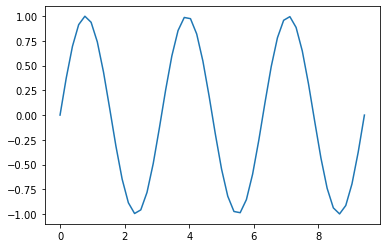

In [47]:
timesteps = 50

x = np.linspace(0,3*np.pi,timesteps)
siny = np.sin(2*x)
plt.plot(x,siny)

Now take slide window to get training data. ith value is predicted from previous k values

In [48]:
k = 4
X = []
y = []
for i in range(k,len(siny)):
    X.append(siny[i-k:i])
    y.append(siny[i])
X = torch.tensor(X).to(device)
y = torch.tensor(y).reshape(-1,1).to(device)
X.shape, y.shape

(torch.Size([46, 4]), torch.Size([46, 1]))

## Training a simple RNN model

I read [gist from karpathy](https://gist.github.com/karpathy/d4dee566867f8291f086) in addition to Karpathy's blog post. Using his notation, there are W_hh, W_xh, W_hy that transform the hidden state h to the next hidden state, transform's the input variable to next hidden state, and transform the hidden state to output. This [blog](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#Creating-the-Network) was also useful but most useful was [fastai deep dive chapter](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb).

In [132]:

class RNN(nn.Module):
    def __init__(self, input_features=4, output_features=1, hidden_size=10):
        super(RNN, self).__init__()
        self.input_features = input_features
        self.W_xh  = randn(hidden_size, 1).double()
        self.W_hh  = randn(hidden_size, hidden_size).double()
        self.W_hy  = randn(hidden_size, output_features).double()
        self.W_xh  = nn.Parameter(self.W_xh)
        self.W_hh  = nn.Parameter(self.W_hh)
        self.W_hy  = nn.Parameter(self.W_hy)
#         self.W_xh  = nn.Linear(1, hidden_size).double()
#         self.W_hh  = nn.Linear(hidden_size,    hidden_size).double()
#         self.W_hy  = nn.Linear(hidden_size,    output_features).double()
#         self.bh =   torch.zeros(hidden_size, 1, dtype=torch.float) 
#         self.by =   torch.zeros(hidden_size, 1, dtype=torch.float) 
        
    def forward(self, x):
        print("x", x.shape)
        batch_size = x.shape[0]
        nfeatures = x.shape[1]
        h = 0 # placeholder: it's actually going to have shape len(x) by hidden_size
        for i in range(nfeatures): # for all input_features
            xi = x[:,i].reshape(1,-1)
            print("xi", xi.shape)
            print("W_xh", self.W_xh.shape)
            h += self.W_xh.mm(xi)
            print("h", h.shape)
            foo = self.W_hh.mm(h)
            print("foo", foo.shape)
            h = torch.relu(foo)
        o = self.W_hy.mm(h)
        return o

In [133]:
rnn = RNN().to(device)
y_pred = rnn(torch.tensor(X,device=device)).detach().cpu()

x torch.Size([46, 4])
xi torch.Size([1, 46])
W_xh torch.Size([10, 1])
h torch.Size([10, 46])
foo torch.Size([10, 46])
xi torch.Size([1, 46])
W_xh torch.Size([10, 1])
h torch.Size([10, 46])
foo torch.Size([10, 46])
xi torch.Size([1, 46])
W_xh torch.Size([10, 1])
h torch.Size([10, 46])
foo torch.Size([10, 46])
xi torch.Size([1, 46])
W_xh torch.Size([10, 1])
h torch.Size([10, 46])
foo torch.Size([10, 46])


/home/parrt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


RuntimeError: size mismatch, m1: [10 x 1], m2: [10 x 46] at /opt/conda/conda-bld/pytorch_1587428266983/work/aten/src/THC/generic/THCTensorMathBlas.cu:283

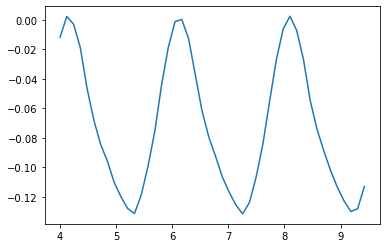

In [131]:
plt.plot(np.linspace(k,3*np.pi,timesteps-k), y_pred)